In [3]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

In [4]:
! pip install tensorflow

### 1. Generate Data

The code in the following cell will generate a set of random `x` values, calculate their sine values, and display them on a graph.

In [1]:
# TensorFlow is an open source machine learning library
import tensorflow as tf

# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
# Numpy is a math library
import numpy as np
# Pandas is a data manipulation library
import pandas as pd
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# Math is Python's math library
import math

# Set seed for experiment reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

2023-01-04 20:58:18.827051: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-04 20:58:18.827079: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


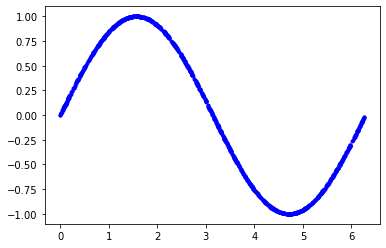

In [5]:
# Number of sample datapoints
SAMPLES = 1000

# Generate a uniformly distributed set of random numbers in the range from
# 0 to 2π, which covers a complete sine wave oscillation
x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES).astype(np.float32)

# Shuffle the values to guarantee they're not in order
np.random.shuffle(x_values)

# Calculate the corresponding sine values
y_values = np.sin(x_values).astype(np.float32)

# Plot our data. The 'b.' argument tells the library to print blue dots.
plt.plot(x_values, y_values, 'b.')
plt.show()

### 2. Add Noise
Since it was generated directly by the sine function, our data fits a nice, smooth curve.

However, machine learning models are good at extracting underlying meaning from messy, real world data. To demonstrate this, we can add some noise to our data to approximate something more life-like.

In the following cell, we'll add some random noise to each value, then draw a new graph:

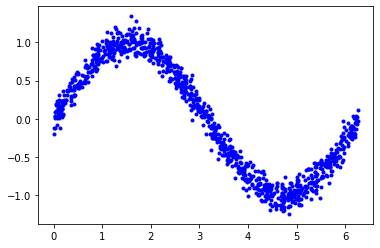

In [6]:
# Add a small random number to each y value
y_values += 0.1 * np.random.randn(*y_values.shape)

# Plot our data
plt.plot(x_values, y_values, 'b.')
plt.show()

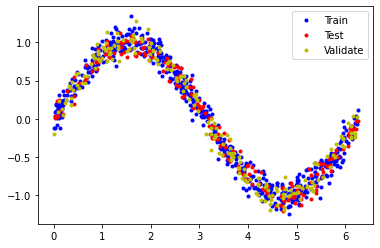

In [7]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()
plt.show()

### 1. Design the Model
We're going to build a simple neural network model that will take an input value (in this case, `x`) and use it to predict a numeric output value (the sine of `x`). This type of problem is called a _regression_. It will use _layers_ of _neurons_ to attempt to learn any patterns underlying the training data, so it can make predictions.

To begin with, we'll define two layers. The first layer takes a single input (our `x` value) and runs it through 8 neurons. Based on this input, each neuron will become _activated_ to a certain degree based on its internal state (its _weight_ and _bias_ values). A neuron's degree of activation is expressed as a number.

The activation numbers from our first layer will be fed as inputs to our second layer, which is a single neuron. It will apply its own weights and bias to these inputs and calculate its own activation, which will be output as our `y` value.

**Note:** To learn more about how neural networks function, you can explore the [Learn TensorFlow](https://codelabs.developers.google.com/codelabs/tensorflow-lab1-helloworld) codelabs.

The code in the following cell defines our model using [Keras](https://www.tensorflow.org/guide/keras), TensorFlow's high-level API for creating deep learning networks. Once the network is defined, we _compile_ it, specifying parameters that determine how it will be trained:

In [9]:
# We'll use Keras to create a simple model architecture
model_1 = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 8 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model_1.add(keras.layers.Dense(8, activation='relu', input_shape=(1,)))

# Final layer is a single neuron, since we want to output a single value
model_1.add(keras.layers.Dense(1))

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model_1.compile(optimizer='adam', loss='mse', metrics=['mae'])
# Train the model on our training data while validating on our validation set
history_1 = model_1.fit(x_train, y_train, epochs=500, batch_size=64,
                        validation_data=(x_validate, y_validate))

2023-01-02 17:08:13.360577: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-01-02 17:08:13.383720: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3193880000 Hz


Epoch 1/500
10/10 [==============================] - 0s 23ms/step - loss: 0.7432 - mae: 0.7217 - val_loss: 0.6433 - val_mae: 0.6531
Epoch 2/500
10/10 [==============================] - 0s 3ms/step - loss: 0.6327 - mae: 0.6490 - val_loss: 0.5482 - val_mae: 0.5972
Epoch 3/500
10/10 [==============================] - 0s 3ms/step - loss: 0.5067 - mae: 0.5656 - val_loss: 0.4799 - val_mae: 0.5655
Epoch 4/500
10/10 [==============================] - 0s 2ms/step - loss: 0.4813 - mae: 0.5627 - val_loss: 0.4353 - val_mae: 0.5489
Epoch 5/500
10/10 [==============================] - 0s 3ms/step - loss: 0.4205 - mae: 0.5311 - val_loss: 0.4087 - val_mae: 0.5407
Epoch 6/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3855 - mae: 0.5166 - val_loss: 0.3937 - val_mae: 0.5369
Epoch 7/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3905 - mae: 0.5222 - val_loss: 0.3856 - val_mae: 0.5346
Epoch 8/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3701 - 

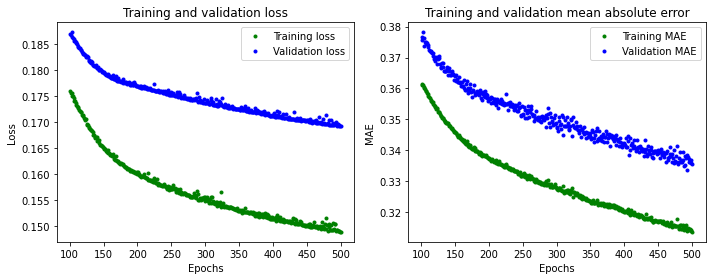

In [28]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Exclude the first few epochs so the graph is easier to read
SKIP = 100

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history_1.history['mae']
val_mae = history_1.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()

The graph shows the _loss_ (or the difference between the model's predictions and the actual data) for each epoch. There are several ways to calculate loss, and the method we have used is _mean squared error_. There is a distinct loss value given for the training and the validation data.

As we can see, the amount of loss rapidly decreases over the first 25 epochs, before flattening out. This means that the model is improving and producing more accurate predictions!

Our goal is to stop training when either the model is no longer improving, or when the _training loss_ is less than the _validation loss_, which would mean that the model has learned to predict the training data so well that it can no longer generalize to new data.

7/7 [==============================] - 0s 562us/step - loss: 0.1461 - mae: 0.3118


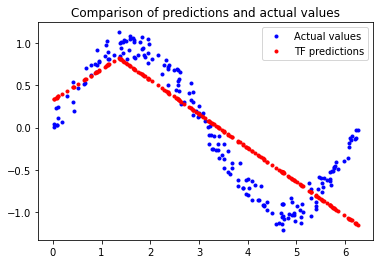

In [18]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model_1.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model_1.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual values')
plt.plot(x_test, y_test_pred, 'r.', label='TF predictions')
plt.legend()
plt.show()

In [48]:
model_2 = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 16 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model_2.add(keras.layers.Dense(16, activation='relu', input_shape=(1,)))

# The new second and third layer will help the network learn more complex representations
model_2.add(keras.layers.Dense(16, activation='relu'))

# Final layer is a single neuron, since we want to output a single value
model_2.add(keras.layers.Dense(1))

# Compile the model using the standard 'adam' optimizer
# and the mean squared error or 'mse' loss function for regression.
model_2.compile(optimizer='adam', loss="mse", metrics=["mae"])

# Train the model
history_2 = model_2.fit(x_train, y_train, epochs=500, batch_size=64,
                    validation_data=(x_validate, y_validate))

# Save the model to disk
model_2.save(MODEL_TF)

Epoch 1/500
10/10 [==============================] - 0s 11ms/step - loss: 0.5308 - mae: 0.5885 - val_loss: 0.4363 - val_mae: 0.5574
Epoch 2/500
10/10 [==============================] - 0s 3ms/step - loss: 0.4260 - mae: 0.5420 - val_loss: 0.4130 - val_mae: 0.5575
Epoch 3/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3864 - mae: 0.5381 - val_loss: 0.4061 - val_mae: 0.5553
Epoch 4/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3967 - mae: 0.5461 - val_loss: 0.3883 - val_mae: 0.5408
Epoch 5/500
10/10 [==============================] - 0s 2ms/step - loss: 0.3711 - mae: 0.5229 - val_loss: 0.3745 - val_mae: 0.5284
Epoch 6/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3494 - mae: 0.5030 - val_loss: 0.3615 - val_mae: 0.5203
Epoch 7/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3555 - mae: 0.5066 - val_loss: 0.3488 - val_mae: 0.5132
Epoch 8/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3303 - 

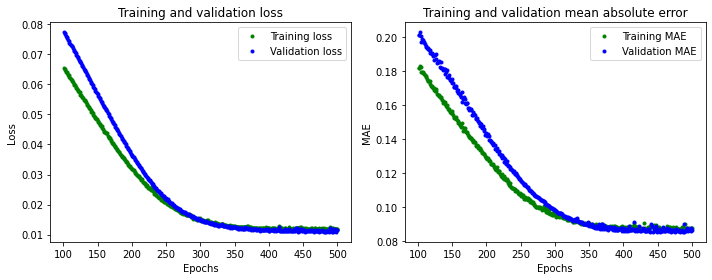

In [27]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Exclude the first few epochs so the graph is easier to read
SKIP = 100

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history_2.history['mae']
val_mae = history_2.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()

7/7 [==============================] - 0s 524us/step - loss: 0.0109 - mae: 0.0836


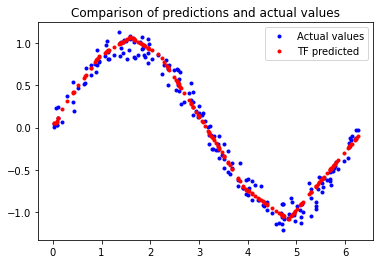

In [49]:
# Calculate and print the loss on our test dataset
test_loss_2, test_mae_2 = model_2.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model_2.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual values')
plt.plot(x_test, y_test_pred, 'r.', label='TF predicted')
plt.legend()
plt.show()

In [52]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

2023-01-02 17:52:55.224144: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored output_format.
2023-01-02 17:52:55.224168: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:319] Ignored drop_control_dependency.
2023-01-02 17:52:55.224172: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:325] Ignored change_concat_input_ranges.
2023-01-02 17:52:55.224308: I tensorflow/cc/saved_model/reader.cc:32] Reading SavedModel from: models/model
2023-01-02 17:52:55.224917: I tensorflow/cc/saved_model/reader.cc:55] Reading meta graph with tags { serve }
2023-01-02 17:52:55.224926: I tensorflow/cc/saved_model/reader.cc:93] Reading SavedModel debug info (if present) from: models/model
2023-01-02 17:52:55.224948: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-02 17:52:55.224961: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor 

2796

In [10]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)


In [11]:
!cat {MODEL_TFLITE_MICRO}

unsigned char models_model_no_quant_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x1c, 0x00, 0x14, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x3c, 0x01, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0xe4, 0x00, 0x00, 0x00, 0x48, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x2c, 0x03, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x44, 0x01, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x98, 0x0a, 0x00, 0x00,
  0x94, 0x0a, 0x00, 0x00, 0xc8, 0x09, 0x00, 0x00, 0x38, 0x09, 0x00, 0x00,
  0xb4, 0x08, 0x00, 0x00, 0x2c, 0x08, 0x00, 0x00, 0xe4, 0x03, 0x00, 0x00,
  0x5c, 0x03, 0x00, 0x00, 0x78, 0x0a, 0x00, 0x00, 0x74, 0x0a, 0x00, 0x00,
  0x70, 0x0a, 0x00, 0x00, 0xd0, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x10, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x10, 0x00, 0